In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd

import matplotlib.pyplot as plt
import numpy as np
import random
import math

import gym
from IPython.display import clear_output
%matplotlib inline
plt.rcParams.update({'font.size': 18})

In [0]:
USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)
USE_CUDA

True

In [0]:
class wrap_pytorch(gym.ObservationWrapper):
    """
    Image shape to num_channels x weight x height
    """
    def __init__(self, env):
        super(wrap_pytorch, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape[-1], old_shape[0], old_shape[1]), dtype=np.uint8)

    def observation(self, observation):
        return np.swapaxes(observation, 2, 0)

#env = make_atari("BoxingNoFrameskip-v0")
#env = wrap_deepmind(env, frame_stack=True)
#env = wrap_pytorch(env)
env = gym.make('CartPole-v1')

print('Observation shape: {}'.format(env.observation_space.shape))
print('Action shape: {}'.format(env.action_space.n))

Observation shape: (4,)
Action shape: 2


In [0]:
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

In [0]:
'''The convolution network used in the experiment is exactly the one
proposed by proposed by Mnih et al. (2015), we only provide de-
tails here for completeness. The input to the network is a 84x84x4
tensor containing a rescaled, and gray-scale, version of the last four
frames. The first convolution layer convolves the input with 32 fil-
ters of size 8 (stride 4), the second layer has 64 layers of size 4
(stride 2), the final convolution layer has 64 filters of size 3 (stride
1). This is followed by a fully-connected hidden layer of 512 units.
All these layers are separated by Rectifier Linear Units (ReLu). Fi-
nally, a fully-connected linear layer projects to the output of the
network, i.e., the Q-values. The optimization employed to train the
network is RMSProp (with momentum parameter 0.95).'''
class ConvDQN(nn.Module):
  def __init__(self, input_shape, num_actions):
    super(ConvDQN, self).__init__()

    assert input_shape == (4,) 
    self.input_shape = input_shape 
    self.num_actions = num_actions

    self.fcs = nn.Sequential(
      nn.Linear(in_features=input_shape[0],
                out_features=20),
      nn.ReLU(),
      nn.Linear(in_features=20,
                out_features=20),
      nn.ReLU(),
      nn.Linear(in_features=20,
                out_features=self.num_actions)
    )

  def forward(self, x):
      x=self.fcs(x)
      return x

  def act(self, state, epsilon):
    with torch.no_grad():
      state   = Variable(torch.FloatTensor(np.float32(state)).unsqueeze(0))
      q_value = self.forward(state)
      
      max_q_val = q_value.max().item()
    if random.random() < epsilon:
      action = random.randrange(env.action_space.n)
    else:
      action = torch.argmax(q_value).item()

    return action,max_q_val

In [0]:
def compute_td_loss(gamma, batch_size):
  state, action, reward, next_state, done = replay_buffer.sample(batch_size)

  state      = Variable(torch.FloatTensor(np.float32(state)))
  next_state = Variable(torch.FloatTensor(np.float32(next_state)))

  action     = Variable(torch.LongTensor(action))
  reward     = Variable(torch.FloatTensor(reward))
  
  done       = Variable(torch.FloatTensor(done))

  #for regular dqn we take the max action from the target network rather 
  #than the online network
  #next_q_val = online_network(next_state)

  
  next_target_values= target_network(next_state)
  #next_target_action = torch.max(next_target_values, 1)[1].unsqueeze(1)
  #estimated_next_q_val = next_target_values.gather(1, next_online_action).squeeze()
  next_target_max_val = torch.max(next_target_values, 1)[0]

  #td_target = Variable((reward+gamma*estimated_next_q_val*(1-done)).data)
  td_target = Variable((reward+gamma*next_target_max_val*(1-done)).data)
  current_q_val = online_network(state)

  q_value = current_q_val.gather(1, action.unsqueeze(1)).squeeze(1)

  #loss_fn = nn.SmoothL1Loss()
  #td_loss = loss_fn(td_target,q_value)
  td_loss = (q_value-td_target).pow(2).mean()

  optimizer.zero_grad()
  td_loss.backward()
  for param in online_network.parameters():
        param.grad.data.clamp_(-1, 1)
  optimizer.step()
    
  return td_loss

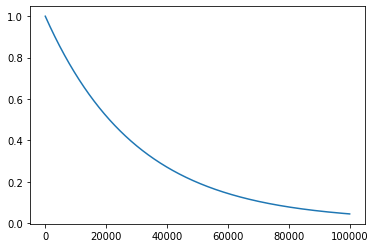

In [0]:
def update_target(online_network, target_network):
    target_network.load_state_dict(online_network.state_dict())

def get_epsilon(start,end,decay_length):
  '''
  Linear decay of epsilon over specified amount of timesteps
  '''
  timestep = 0
  eps_decrease = (start-end)/decay_length
  epsilon = start
  while True:
    yield epsilon
    timestep+=1
    epsilon = end + (start - end) * math.exp(-1. * timestep / decay_length)
    #epsilon+=-eps_decrease

get_eps = get_epsilon(1,0.01,30000)
x = [next(get_eps) for i in range(100000)]
plt.plot(x)

In [0]:
save_online_path = 'cartpole_dqn_online.pth'
online_network=ConvDQN(env.observation_space.shape, env.action_space.n)
try:
  #online_network.load_state_dict(torch.load(save_online_path))
  print('Using model from {}'.format(save_online_path))
except:
  pass
target_network=ConvDQN(env.observation_space.shape, env.action_space.n)

if USE_CUDA:
  print('Using GPU')
  online_network = online_network.cuda()
  target_network = target_network.cuda()

optimizer = optim.Adam(lr=0.001,params=online_network.parameters())

Using model from cartpole_dqn_online.pth
Using GPU


In [0]:
def plot(rewards, loss, max_q_values):
  clear_output(True)
  fig1,ax1 = plt.subplots(1,3, figsize=(30,10))

  ax1[0].plot(rewards)
  ax1[0].set_title('Rewards per Episode')
  ax1[0].set_xlabel('Episode')
  ax1[0].set_ylabel('Reward')
  
  ax1[1].plot(loss)
  ax1[1].set_title('DQN Loss')
  ax1[1].set_ylabel('Loss')
  ax1[1].set_xlabel('Timesteps')

  ax1[2].plot(max_q_values)
  ax1[2].set_title('Max Q Values')
  ax1[2].set_ylabel('Max Action Value')
  ax1[2].set_xlabel('Timesteps')  
  plt.show()

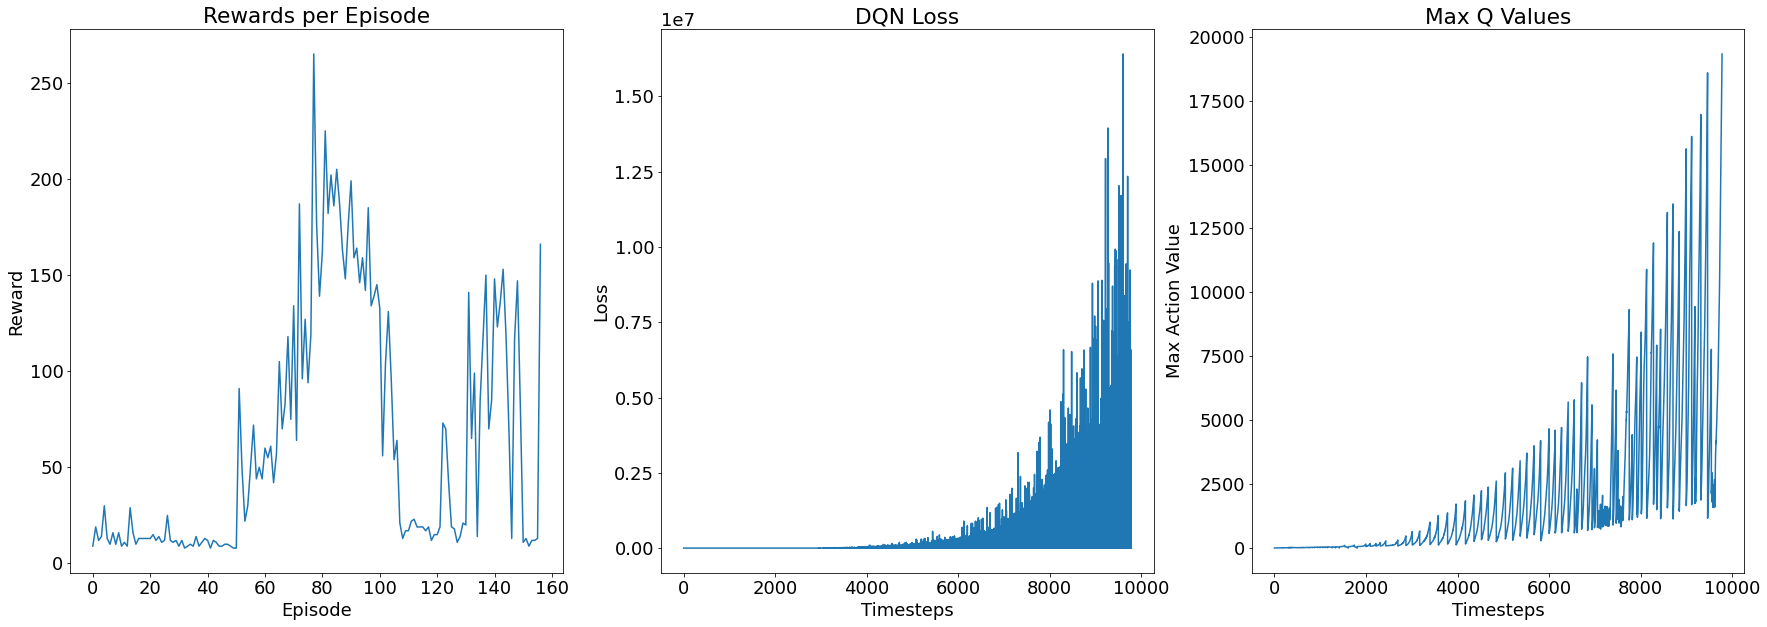

Training reward mean: 63.59235668789809


In [0]:
loss = []
rewards = []
episode_reward = 0
replay_initial = 200
replay_buffer = ReplayBuffer(100000)
max_q_vals = np.array([])
state=env.reset()
get_eps = get_epsilon(start=1,
                      end=0.05,
                      decay_length=300)



for timestep in range(1,10000):
  eps = next(get_eps)
  action, max_q_val = online_network.act(state=state,epsilon=eps)
  next_state, reward, done, _ = env.step(action)
  replay_buffer.push(state,action,reward,next_state,done)

  
  state = next_state
  episode_reward+=reward

  if done:
    state=env.reset()
    rewards.append(episode_reward)
    episode_reward=0
    plot(rewards,loss,max_q_vals)
    print('Training reward mean: {}'.format(np.mean(rewards)))

  if len(replay_buffer)>replay_initial:
    max_q_vals = np.append(max_q_vals,max_q_val)
    td_loss = compute_td_loss(gamma=0.99,
                              batch_size=64)
    loss.append(td_loss)
  
  if timestep % 10==0:
    update_target(online_network,target_network)

  if timestep % 1000 == 0:
    torch.save(online_network.state_dict(), save_online_path)

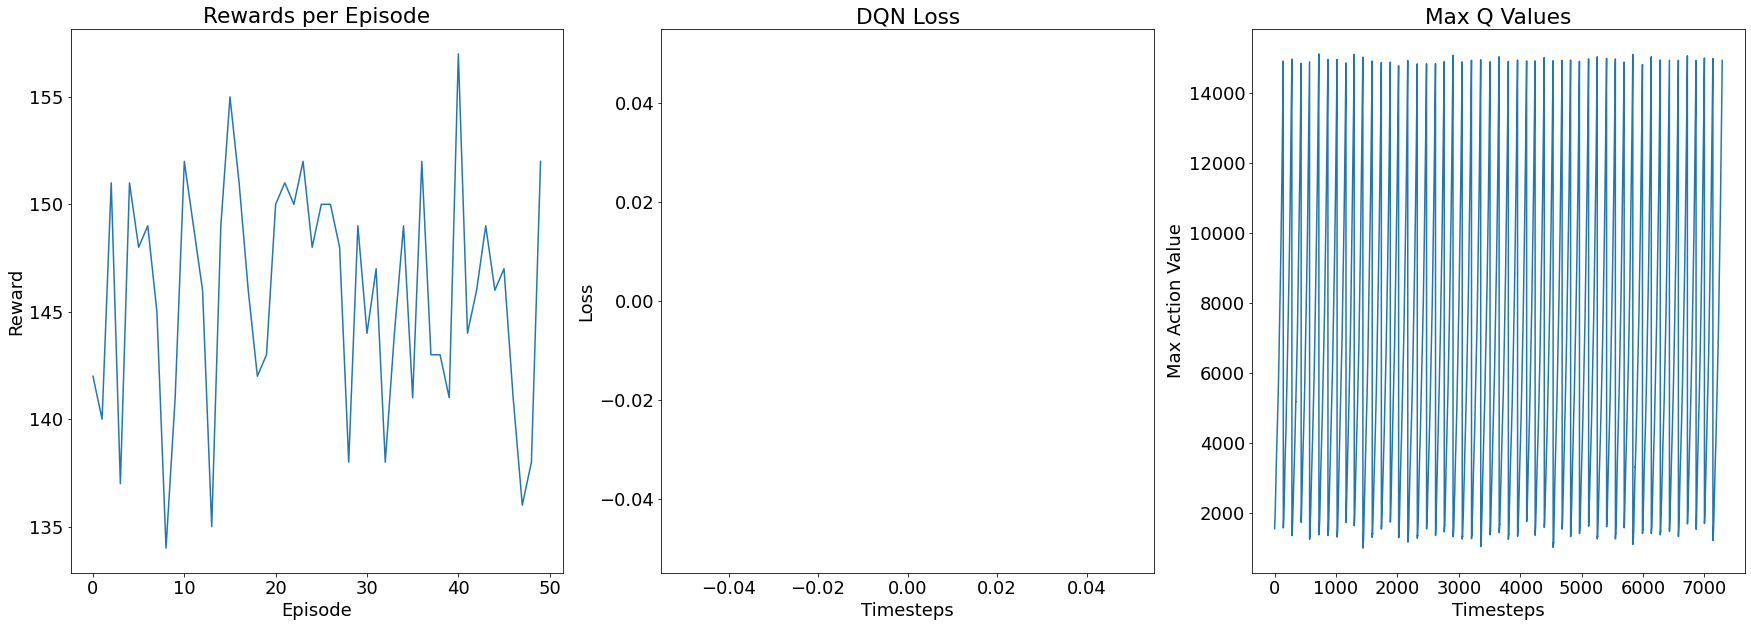

Average Eval Reward:145.8


In [0]:
online_network=ConvDQN(env.observation_space.shape, env.action_space.n)

try:
  online_network.load_state_dict(torch.load(save_online_path))
  print('Using model from {}'.format(save_online_path))
except:
  pass
  
if USE_CUDA:
  print('Using GPU')
  online_network = online_network.cuda()
eval_rewards = []
max_q_vals = np.array([])
loss = []
eps = 0.05
episode_reward = 0
state = env.reset()
done=0
for eval_ep in range(50):
  while not done:
    action, max_q_val = online_network.act(state=state,epsilon=eps)
    max_q_vals = np.append(max_q_vals, max_q_val)
    next_state, reward, done, _ = env.step(action)

    episode_reward+=reward
    state=next_state

  
  eval_rewards.append(episode_reward)
  episode_reward=0
  done=0
  plot(eval_rewards,[],max_q_vals)
  state=env.reset()
print('Average Eval Reward:{}'.format(np.mean(eval_rewards)))

In [0]:
np.mean(eval_rewards)

-33.22

Text(0, 0.5, 'Reward')

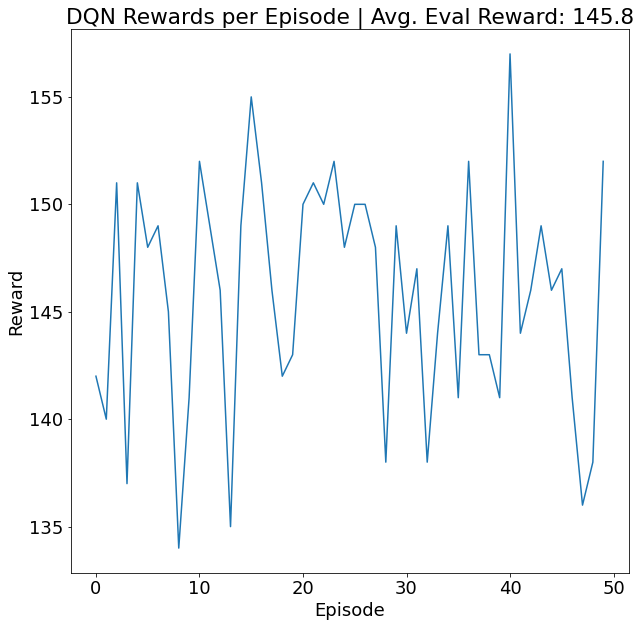

In [0]:
fig,ax = plt.subplots(figsize=(10,10))

ax.plot(eval_rewards)
ax.set_title('DQN Rewards per Episode | Avg. Eval Reward: {}'.format(np.mean(eval_rewards)))
ax.set_xlabel('Episode')
ax.set_ylabel('Reward')